In [1]:
import os
import json
from pprint import pprint

from datasets import load_dataset
import pandas as pd
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

import promptquality as pq
from tqdm import tqdm
tqdm.pandas()

load_dotenv("../.env")

True

In [2]:
df = load_dataset("Salesforce/xlam-function-calling-60k", split="train").to_pandas()
df.head()

,query,id,answers,tools
0,Where can I find live giveaways for beta acces...,0,"[{""name"": ""live_giveaways_by_type"", ""arguments...","[{""name"": ""live_giveaways_by_type"", ""descripti..."
1,I need to understand the details of the Ethere...,1,"[{""name"": ""web_chain_details"", ""arguments"": {""...","[{""name"": ""peers"", ""description"": ""Retrieves a..."
2,What is the T3MA for 'ETH/BTC' using a 1h inte...,2,"[{""name"": ""t3ma"", ""arguments"": {""symbol"": ""ETH...","[{""name"": ""t3ma"", ""description"": ""Fetches the ..."
3,List titles originally aired on networks '1' a...,3,"[{""name"": ""list_titles"", ""arguments"": {""networ...","[{""name"": ""get_animes"", ""description"": ""Retrie..."
4,Fetch the competitor standings for the recentl...,4,"[{""name"": ""stagecompetitorstandings"", ""argumen...","[{""name"": ""stagecompetitorstandings"", ""descrip..."


In [3]:
df["tools"] = df["tools"].apply(json.loads)
df["answers"] = df["answers"].apply(json.loads)
df["n_tools"] = df.tools.apply(lambda x: len(x))
df["len_query"] = df["query"].apply(lambda x: len(x))
df["n_function_calls"] = df["answers"].apply(lambda x: len(x))
df["n_turns"] = 1
df.head()

,query,id,answers,tools,n_tools,len_query,n_function_calls,n_turns
0,Where can I find live giveaways for beta acces...,0,"[{'name': 'live_giveaways_by_type', 'arguments...","[{'name': 'live_giveaways_by_type', 'descripti...",1,58,2,1
1,I need to understand the details of the Ethere...,1,"[{'name': 'web_chain_details', 'arguments': {'...","[{'name': 'peers', 'description': 'Retrieves a...",2,132,1,1
2,What is the T3MA for 'ETH/BTC' using a 1h inte...,2,"[{'name': 't3ma', 'arguments': {'symbol': 'ETH...","[{'name': 't3ma', 'description': 'Fetches the ...",2,75,1,1
3,List titles originally aired on networks '1' a...,3,"[{'name': 'list_titles', 'arguments': {'networ...","[{'name': 'get_animes', 'description': 'Retrie...",2,118,1,1
4,Fetch the competitor standings for the recentl...,4,"[{'name': 'stagecompetitorstandings', 'argumen...","[{'name': 'stagecompetitorstandings', 'descrip...",1,70,1,1


In [4]:
df.n_function_calls.value_counts()

n_function_calls
1     28461
2     25422
3      4697
4      1056
5       187
6        94
7        20
10       19
9        12
8        12
12        6
11        4
14        2
20        2
30        1
23        1
52        1
26        1
19        1
24        1
Name: count, dtype: int64

In [5]:
df.n_tools.value_counts()

n_tools
1    15410
4    13078
2    12726
3    12655
5     2427
6     1464
8     1132
7     1108
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

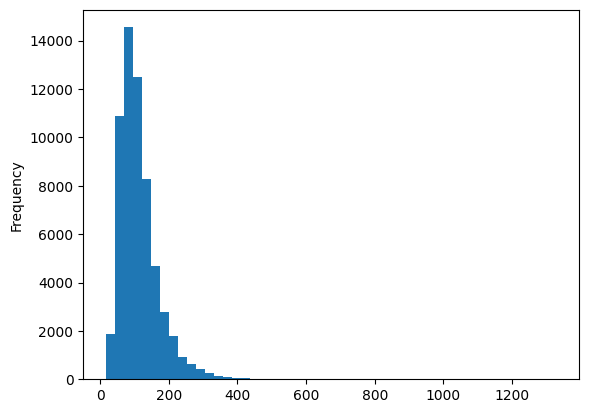

In [6]:
df["len_query"].plot.hist(bins=50)

In [7]:
single_tool_single_call = df.query("len_query > 230 and n_tools == 1 and n_function_calls == 1").sample(100, random_state=42)
single_tool_single_call.head()

,query,id,answers,tools,n_tools,len_query,n_function_calls,n_turns
35918,You receive an email from an unknown sender wi...,35918,"[{'name': 'chat_gpt_detector', 'arguments': {'...","[{'name': 'chat_gpt_detector', 'description': ...",1,312,1,1
49404,Can you conduct a t-test to determine if there...,49404,"[{'name': 'independent_samples_t_test', 'argum...","[{'name': 'independent_samples_t_test', 'descr...",1,256,1,1
49154,A biologist is studying a bacterial culture wi...,49154,"[{'name': 'bacterial_growth', 'arguments': {'i...","[{'name': 'bacterial_growth', 'description': '...",1,252,1,1
45209,Find popular tourist attractions within a 5000...,45209,[{'name': 'places_list_by_radius_nearby_search...,[{'name': 'places_list_by_radius_nearby_search...,1,233,1,1
41547,"A list of numbers from 0 to 40 is given, but o...",41547,"[{'name': 'find_missing_number', 'arguments': ...","[{'name': 'find_missing_number', 'description'...",1,263,1,1


In [8]:
multiple_tool_single_call = df.query("len_query > 230 and n_tools > 1 and n_function_calls == 1").sample(100, random_state=42)
multiple_tool_single_call.head()

,query,id,answers,tools,n_tools,len_query,n_function_calls,n_turns
17443,Calculate the distance and time it takes to tr...,17443,"[{'name': 'directions_between_2_locations', 'a...","[{'name': 'get_countries', 'description': 'Fet...",4,235,1,1
33976,I have an initial investment of $1000 and I ad...,33976,"[{'name': 'project_investment_growth', 'argume...","[{'name': 'calculate_order_total', 'descriptio...",3,253,1,1
51943,"I'm planning to invest $5,000, and I want to a...",51943,"[{'name': 'project_investment_growth', 'argume...","[{'name': 'get_ip_zipcode', 'description': 'Re...",2,234,1,1
24593,Verify if a Sudoku board with the following co...,24593,"[{'name': 'is_valid_sudoku', 'arguments': {'bo...","[{'name': 'is_valid_sudoku', 'description': 'C...",3,492,1,1
37689,Calculate the total alimony one spouse would h...,37689,"[{'name': 'california_alimony', 'arguments': {...","[{'name': 'is_valid_palindrome', 'description'...",5,241,1,1


In [9]:
single_tool_multiple_call = df.query("len_query > 250 and n_tools == 1 and n_function_calls > 1").sample(50, random_state=42)
single_tool_multiple_call.head()

,query,id,answers,tools,n_tools,len_query,n_function_calls,n_turns
8693,Could you fetch the English map tile for the l...,8693,"[{'name': 'en_map_v1_z_x_y_png', 'arguments': ...","[{'name': 'en_map_v1_z_x_y_png', 'description'...",1,258,3,1
46580,I need the details of all Litecoin blocks mine...,46580,[{'name': 'get_litecoin_block_by_hash_or_heigh...,[{'name': 'get_litecoin_block_by_hash_or_heigh...,1,294,3,1
12868,I need to find photos of three different busin...,12868,"[{'name': 'business_photos', 'arguments': {'bu...","[{'name': 'business_photos', 'description': 'F...",1,323,3,1
44394,Calculate the recommended daily calorie intake...,44394,"[{'name': 'calculate_calorie_intake', 'argumen...","[{'name': 'calculate_calorie_intake', 'descrip...",1,314,2,1
48976,Please search for a product on Tokopedia using...,48976,"[{'name': 'search_product', 'arguments': {'que...","[{'name': 'search_product', 'description': 'Th...",1,320,3,1


In [10]:
single_tool_multiple_call.n_function_calls.value_counts()

n_function_calls
2     25
3     18
4      3
5      2
7      1
10     1
Name: count, dtype: int64

In [11]:
total_rows = 200

multiple_tool_multiple_call_long_query = df.query("len_query > 100 and n_tools > 1 and n_function_calls > 1")

# select 10 samples for each n_function_calls where 1<n_tools<8 and 1<n_function_calls<6
n_answers_samples = []
for i in range(2, 8):
    temp = multiple_tool_multiple_call_long_query.query(f"n_tools == {i}")
    if len(temp) > 20:
        temp = temp.sample(20, random_state=42)
    n_answers_samples.append(temp)
    
for i in range(2, 6):
    temp = multiple_tool_multiple_call_long_query.query(f"n_function_calls == {i}")
    if len(temp) > 20:
        temp = temp.sample(20, random_state=42)
    n_answers_samples.append(temp)
    
temp = pd.concat(n_answers_samples)
temp = temp.drop_duplicates("query")

remaining = total_rows - len(temp)
if remaining:
    # select remaining samples randomly 
    multiple_tool_multiple_call = pd.concat([temp, multiple_tool_multiple_call_long_query.sample(remaining, random_state=42)])

print(len(multiple_tool_multiple_call.drop_duplicates("query")))
multiple_tool_multiple_call.head()

200


,query,id,answers,tools,n_tools,len_query,n_function_calls,n_turns
9897,Could you please check the current stock price...,9897,"[{'name': 'price_by_symbol', 'arguments': {'in...","[{'name': 'price_by_symbol', 'description': 'F...",2,140,2,1
38837,I want to know the return on investment for an...,38837,"[{'name': 'calculate_investment_return', 'argu...","[{'name': 'calculate_investment_return', 'desc...",2,233,2,1
56946,Find out the car models produced by Honda. Sho...,56946,"[{'name': 'get_car_models', 'arguments': {'mak...","[{'name': 'get_car_models', 'description': 'Fe...",2,106,2,1
57598,Who owns the domain 'example.com' and what is ...,57598,"[{'name': 'whois', 'arguments': {'domain': 'ex...","[{'name': 'whois', 'description': 'Queries a W...",2,118,2,1
52753,I'm planning a trip to Tunisia and I want to v...,52753,"[{'name': 'geocode', 'arguments': {'address': ...","[{'name': 'reverse_php', 'description': 'Perfo...",2,240,2,1


In [12]:
# get value counts on temp for n_answers and n_tools
temp.n_tools.value_counts(), temp.n_function_calls.value_counts()

(n_tools
 4    45
 3    44
 2    40
 5    24
 6    22
 7    22
 Name: count, dtype: int64,
 n_function_calls
 2    121
 3     33
 4     22
 5     21
 Name: count, dtype: int64)

In [13]:
# i = 2
# test = temp[temp.n_function_calls == 5]
# test["query"].values[i], test.tools.values[i], test.answers.values[i]

In [14]:
total_rows = 200

df_long_query = df.query("len_query > 100")

# select 10 samples for each n_function_calls where 1<n_tools<8 and 1<n_function_calls<6
n_answers_samples = []
for i in range(1, 8):
    temp = df_long_query.query(f"n_tools == {i}")
    if len(temp) > 20:
        temp = temp.sample(20, random_state=0)
    n_answers_samples.append(temp)
    
for i in range(1, 6):
    temp = df_long_query.query(f"n_function_calls == {i}")
    if len(temp) > 10:
        temp = temp.sample(10, random_state=0)
    n_answers_samples.append(temp)
    
temp = pd.concat(n_answers_samples)
temp = temp.drop_duplicates("query")

print(len(temp))

remaining = total_rows - len(temp)
if remaining:
    # select remaining samples randomly 
    tool_miss = pd.concat([temp, df_long_query.sample(remaining, random_state=0)])

print(len(tool_miss.drop_duplicates("query")))
tool_miss.head()

189
200


,query,id,answers,tools,n_tools,len_query,n_function_calls,n_turns
15695,I'm planning a trip to Japan and want to know ...,15695,"[{'name': 'search', 'arguments': {'search': 'J...","[{'name': 'search', 'description': 'Searches b...",1,198,2,1
9275,I'm interested in the LN of the low prices for...,9275,"[{'name': 'ln', 'arguments': {'symbol': 'IXIC'...","[{'name': 'ln', 'description': 'Returns the na...",1,145,1,1
36813,"I need to sort the numbers 1.1, 2.2, and 3.3, ...",36813,"[{'name': 'sort_numbers', 'arguments': {'numbe...","[{'name': 'sort_numbers', 'description': 'Sort...",1,115,2,1
48546,Find potentially undervalued large cap stocks ...,48546,"[{'name': 'market_undervalued_large_caps', 'ar...","[{'name': 'market_undervalued_large_caps', 'de...",1,104,3,1
47954,"I'm designing a triangular sail for my boat, a...",47954,"[{'name': 'triangle_area', 'arguments': {'base...","[{'name': 'triangle_area', 'description': 'Com...",1,167,1,1


In [15]:
tool_miss.n_tools.value_counts(), tool_miss.n_function_calls.value_counts()

(n_tools
 4    41
 1    32
 3    29
 2    28
 5    25
 6    22
 7    22
 8     1
 Name: count, dtype: int64,
 n_function_calls
 2    94
 1    43
 3    35
 4    17
 5    10
 9     1
 Name: count, dtype: int64)

In [16]:


# tools = [{'name': 'price_by_symbol',
#   'description': 'Fetches the live price of a stock by its symbol.',
#   'parameters': {'input': {'description': 'The stock symbol to query.',
#     'type': 'str',
#     'default': 'AAPL'}}},
#  {'name': 'stock_earnings',
#   'description': 'Retrieve earnings information for a particular stock symbol using the Yahoo Finance API.',
#   'parameters': {'symbol': {'description': 'The stock symbol for which to retrieve earnings information.',
#     'type': 'str',
#     'default': 'AAPL'}}}]

# answers =  [{'name': 'price_by_symbol', 'arguments': {'input': 'AAPL'}},
#   {'name': 'stock_earnings', 'arguments': {'symbol': 'MSFT'}}])


# write a func to do following steps for above tools and answers
# 1. select random tool name from answers
# 2. remove that tool from tools

def remove_tools(tools, answers):
    import random
    tool_removed = random.choice(answers)
    answers = [ans for ans in answers if ans["name"] != tool_removed["name"]]
    tools = [t for t in tools if t["name"] != tool_removed["name"]]
    return tools, answers, tool_removed

# apply this func to col tools and answers of df
tool_miss["tools"], tool_miss["answers"], tool_miss["tool_removed"] = zip(*tool_miss.progress_apply(lambda x: remove_tools(x["tools"], x["answers"]), axis=1))
tool_miss["n_tools"] = tool_miss.tools.apply(lambda x: len(x))
tool_miss = tool_miss[tool_miss.n_tools > 0].sample(100, random_state=42)
tool_miss["n_function_calls"] = tool_miss["answers"].apply(lambda x: len(x))
tool_miss.head()

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 13406.54it/s]


,query,id,answers,tools,n_tools,len_query,n_function_calls,n_turns,tool_removed
15737,"Reverse the string 'Algorithm', calculate the ...",15737,"[{'name': 'calculate_grade', 'arguments': {'sc...","[{'name': 'is_anagram', 'description': 'Checks...",5,149,2,1,"{'name': 'reverse_string', 'arguments': {'text..."
53488,Search for financial stocks related to 'google...,53488,"[{'name': 'get_2_stockdetails', 'arguments': {...","[{'name': 'get_2_stockdetails', 'description':...",2,116,1,1,"{'name': 'search', 'arguments': {'query': 'goo..."
20492,Fetch user information for email 'example@emai...,20492,"[{'name': 'dashboard', 'arguments': {'login_id...","[{'name': 'getpetbyid', 'description': 'Get de...",6,149,1,1,"{'name': 'getusers', 'arguments': {'email': 'e..."
55623,Get the live match data for match ID '6789' an...,55623,"[{'name': 'summary', 'arguments': {'identifier...","[{'name': 'summary', 'description': 'Fetches t...",2,120,1,1,"{'name': 'provider1_live_match_id', 'arguments..."
53985,I'd like to know the revenue estimate for Micr...,53985,"[{'name': 'revenue_estimate', 'arguments': {'t...","[{'name': 'revenue_estimate', 'description': '...",3,221,3,1,"{'name': 'time_series', 'arguments': {'symbol'..."


In [17]:
tool_miss.tail()

,query,id,answers,tools,n_tools,len_query,n_function_calls,n_turns,tool_removed
39668,Calculate the quarterly dividend per share for...,39668,"[{'name': 'least_common_multiple', 'arguments'...","[{'name': 'independent_samples_t_test', 'descr...",4,174,1,1,"{'name': 'calculate_quarterly_dividend', 'argu..."
44488,Retrieve the cash flow statement for Tesla and...,44488,"[{'name': 'stock_cashflow_statement', 'argumen...","[{'name': 'stock_cashflow_statement', 'descrip...",2,216,2,1,"{'name': 'aroon', 'arguments': {'symbol': 'BTC..."
28392,"I need to find the 10th Fibonacci number, the ...",28392,"[{'name': 'fibonacci', 'arguments': {'n': 10}}...","[{'name': 'fibonacci', 'description': 'Calcula...",6,250,4,1,"{'name': 'find_max_subarray_sum', 'arguments':..."
4748,A conference organizer has the following sched...,4748,[],"[{'name': 'displacement', 'description': 'Calc...",2,185,0,1,"{'name': 'min_meeting_rooms', 'arguments': {'i..."
23625,Compute the Euclidean distance between points ...,23625,"[{'name': 'euclidean_distance', 'arguments': {...","[{'name': 'find_equilibrium_index', 'descripti...",2,212,1,1,"{'name': 'neuronal_activity_rate', 'arguments'..."


In [18]:
def convert_tools_to_langchain_format(tools):
    def convert_type(t):
        type_mapping = {
            "float": "number",
            "int": "integer",
            "str": "string",
            "bool": "boolean",
            "dict": "object",
            "list": "array"
        }
        return type_mapping.get(t.lower() if isinstance(t, str) else t, "string")
    
    def convert_parameter(param_info):
        prop = {
            "description": param_info["description"],
            "type": convert_type(param_info["type"])
        }
        
        if prop["type"] == "array":
            # Default to string items if not specified
            prop["items"] = {"type": "string"}
            
            # If item type is specified in the description, try to infer it
            desc_lower = param_info["description"].lower()
            if "integer" in desc_lower or "number" in desc_lower:
                prop["items"]["type"] = "number"
            elif "boolean" in desc_lower:
                prop["items"]["type"] = "boolean"
        
        return prop

    def convert_single_tool(tool):
        properties = {}
        required = []
        
        for param_name, param_info in tool["parameters"].items():
            prop = convert_parameter(param_info)
            prop["title"] = param_name.title()
            
            if "default" not in param_info:
                required.append(param_name)
                
            properties[param_name] = prop

        return {
            "description": tool["description"],
            "properties": properties,
            "required": required,
            "title": tool["name"],
            "type": "object"
        }

    if isinstance(tools, list):
        return [convert_single_tool(tool) for tool in tools]
    elif isinstance(tools, dict):
        return convert_single_tool(tools)
    else:
        raise ValueError("Input must be either a single tool dict or a list of tool dicts")

def remove_duplicate_tools(tools_langchain):
    unique_tools = []
    unique_tool_names = set()
    for tool in tools_langchain:
        if tool["title"] not in unique_tool_names:
            unique_tools.append(tool)
            unique_tool_names.add(tool["title"])
    return unique_tools

for temp, name in [
                   (single_tool_single_call, "xlam_single_tool_single_call"),
                   (multiple_tool_single_call, "xlam_multiple_tool_single_call"), 
                   (single_tool_multiple_call, "xlam_single_tool_multiple_call"),
                   (multiple_tool_multiple_call, "xlam_multiple_tool_multiple_call"),
                   (tool_miss, "xlam_tool_miss")]:
    temp["tools_langchain"] = temp["tools"].apply(convert_tools_to_langchain_format)
    temp = temp.rename(columns={"query": "conversation"})
    temp["conversation"] = temp["conversation"].apply(lambda x: [{"role": "user", "content": x}])
    temp["tools_langchain"] = temp["tools_langchain"].apply(remove_duplicate_tools)
    print(name, temp.shape)
    temp.to_parquet(f"../data/datasets/{name}.parquet", engine="fastparquet")

xlam_single_tool_single_call (100, 9)
xlam_multiple_tool_single_call (100, 9)
xlam_single_tool_multiple_call (50, 9)
xlam_multiple_tool_multiple_call (200, 9)
xlam_tool_miss (100, 10)
